In [320]:
import torch
import numpy as np
from torch import nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from torchmetrics import Accuracy

NUM_SAMPLES = 1000
NOISE = 0.10
RANDOM_SEED = 42
TEST_SIZE = 0.2
LEARNING_RATE = 0.1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 10000

In [321]:
class Classifier(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=16):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units, device=DEVICE),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units, device=DEVICE),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units, device=DEVICE),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features, device=DEVICE),
        )
        self.n_classes=output_features

    def forward(self, x):
        return self.linear_layer_stack(x)
    
    def predict(self, x):
        self.eval()
        with torch.inference_mode():
            if self.n_classes == 1:
                return torch.round(torch.sigmoid(self.forward(x)))
            else:
                return torch.argmax(torch.softmax(self.forward(x), dim=1), dim=1)

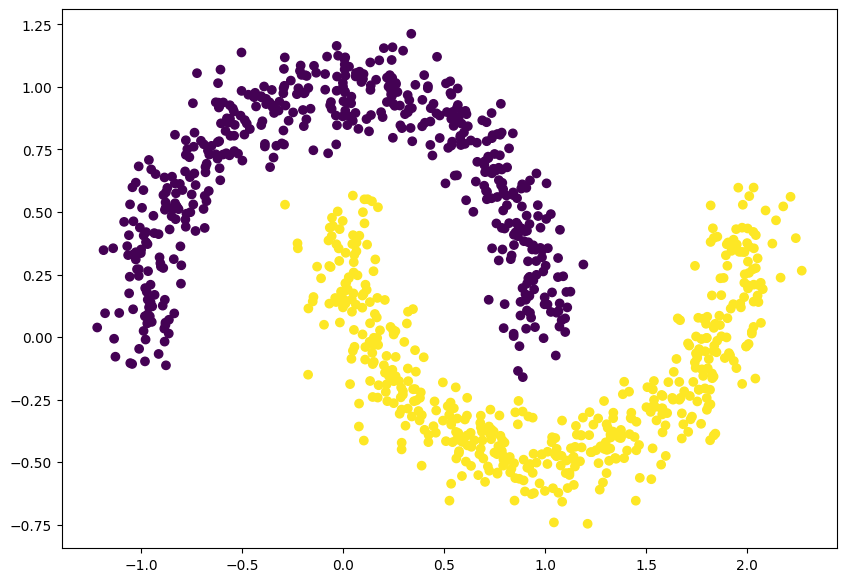

In [296]:
X, y = make_moons(n_samples=NUM_SAMPLES, noise=NOISE, random_state=RANDOM_SEED)
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=y)

In [322]:
model = Classifier(input_features=2, output_features=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
acc_fn = Accuracy(task="binary").to(DEVICE)

y_logits = model(X_train.to(DEVICE))
y_preds = torch.round(torch.sigmoid(y_logits))

In [302]:
X_train, X_test, y_train, y_test = X_train.to(DEVICE), X_test.to(DEVICE), y_train.to(DEVICE).float(), y_test.to(DEVICE).float()

for epoch in range(EPOCHS):
    model.train()

    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)).squeeze()

    loss = loss_fn(y_logits, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    acc = acc_fn(y_pred, y_train)
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.72500, Acc: 0.50% | Test Loss: 0.71922, Test Acc: 0.50%
Epoch: 100 | Loss: 0.31254, Acc: 0.86% | Test Loss: 0.31850, Test Acc: 0.85%
Epoch: 200 | Loss: 0.22011, Acc: 0.90% | Test Loss: 0.21156, Test Acc: 0.92%
Epoch: 300 | Loss: 0.15877, Acc: 0.93% | Test Loss: 0.14752, Test Acc: 0.94%
Epoch: 400 | Loss: 0.08073, Acc: 0.98% | Test Loss: 0.06864, Test Acc: 0.98%
Epoch: 500 | Loss: 0.03501, Acc: 0.99% | Test Loss: 0.02701, Test Acc: 1.00%
Epoch: 600 | Loss: 0.01950, Acc: 1.00% | Test Loss: 0.01414, Test Acc: 1.00%
Epoch: 700 | Loss: 0.01323, Acc: 1.00% | Test Loss: 0.00914, Test Acc: 1.00%
Epoch: 800 | Loss: 0.00997, Acc: 1.00% | Test Loss: 0.00665, Test Acc: 1.00%
Epoch: 900 | Loss: 0.00798, Acc: 1.00% | Test Loss: 0.00516, Test Acc: 1.00%
Epoch: 1000 | Loss: 0.00665, Acc: 1.00% | Test Loss: 0.00420, Test Acc: 1.00%
Epoch: 1100 | Loss: 0.00568, Acc: 1.00% | Test Loss: 0.00352, Test Acc: 1.00%
Epoch: 1200 | Loss: 0.00494, Acc: 1.00% | Test Loss: 0.00302, Test Acc: 1.00

In [299]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


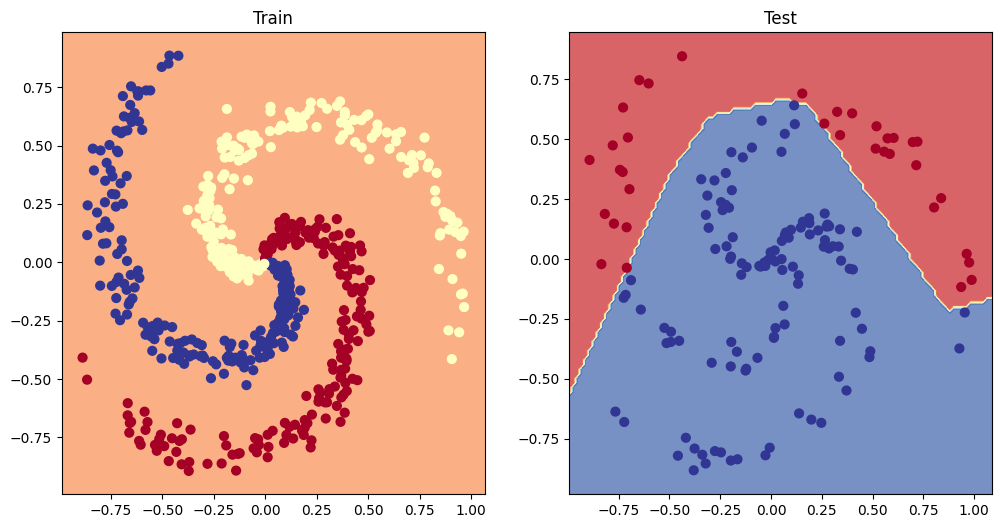

In [309]:
y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_pred)

In [142]:
def tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

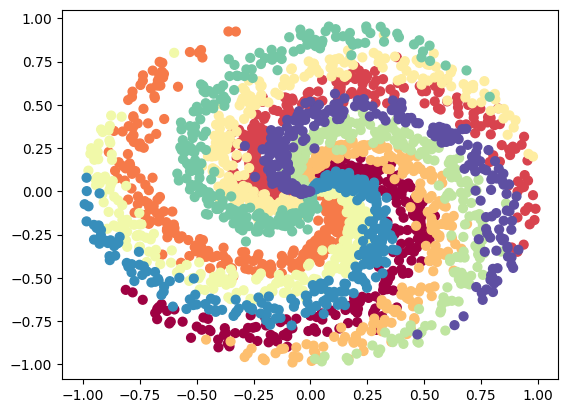

In [323]:
N = 250 # number of points per class
D = 2 # dimensionality
K = 10 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [328]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)
X_train, X_test = torch.from_numpy(X_train).type(torch.float), torch.from_numpy(X_test).type(torch.float)
y_train, y_test = torch.from_numpy(y_train).type(torch.LongTensor), torch.from_numpy(y_test).type(torch.LongTensor)

In [329]:
model_spiral = Classifier(input_features=D, output_features=K, hidden_units=32)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_spiral.parameters(),lr=LEARNING_RATE)
acc_fn = Accuracy(task="multiclass", num_classes=K)

for epoch in range(EPOCHS):
    model_spiral.train()

    y_logits = model_spiral(X_train)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_spiral.eval()
    with torch.inference_mode():
        test_logits = model_spiral(X_test)
        test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.30502, Acc: 0.07% | Test Loss: 2.30058, Test Acc: 0.08%
Epoch: 100 | Loss: 1.97995, Acc: 0.18% | Test Loss: 2.00080, Test Acc: 0.15%
Epoch: 200 | Loss: 1.85040, Acc: 0.19% | Test Loss: 1.88348, Test Acc: 0.18%
Epoch: 300 | Loss: 1.68530, Acc: 0.25% | Test Loss: 1.70809, Test Acc: 0.22%
Epoch: 400 | Loss: 1.52455, Acc: 0.40% | Test Loss: 1.50409, Test Acc: 0.39%
Epoch: 500 | Loss: 1.29823, Acc: 0.53% | Test Loss: 1.34098, Test Acc: 0.49%
Epoch: 600 | Loss: 1.14067, Acc: 0.56% | Test Loss: 1.14392, Test Acc: 0.54%
Epoch: 700 | Loss: 0.99889, Acc: 0.62% | Test Loss: 0.95687, Test Acc: 0.63%
Epoch: 800 | Loss: 0.95645, Acc: 0.63% | Test Loss: 0.94390, Test Acc: 0.61%
Epoch: 900 | Loss: 0.84686, Acc: 0.66% | Test Loss: 0.86781, Test Acc: 0.65%
Epoch: 1000 | Loss: 0.80978, Acc: 0.68% | Test Loss: 0.87022, Test Acc: 0.64%
Epoch: 1100 | Loss: 0.72059, Acc: 0.73% | Test Loss: 0.70224, Test Acc: 0.71%
Epoch: 1200 | Loss: 0.71791, Acc: 0.71% | Test Loss: 0.67576, Test Acc: 0.72

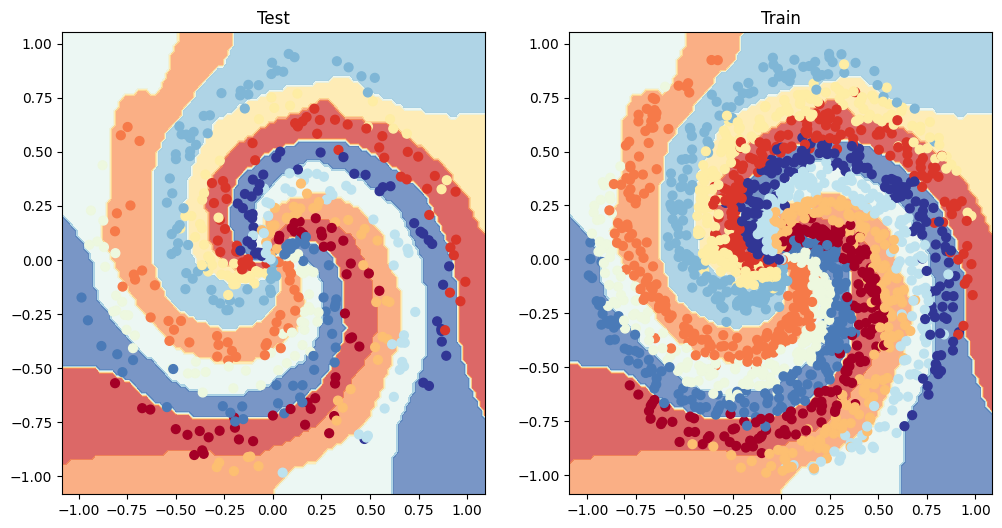

In [333]:
y_pred = model_spiral.predict(X_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Test")
plot_decision_boundary(model_spiral, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title("Train")
plot_decision_boundary(model_spiral, X_train, y_train)